# Model Results Visualization
This notebook is intended to pull model artifacts from the Neptune experiment logger and run it on a few samples from the dataset to see visualize how the different model's are segmenting the data. 

In [1]:
from neptune import Session
import pickle
from rasterio.plot import show
import pytorch_lightning as pl
import torch
import torchvision
import zipfile
from matplotlib import pyplot
import numpy as np
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import segmentation_models_pytorch as smp

In [2]:
image_types = ['full_channel', 'rgb', 'ir', 'hsv', 'hsv_with_ir', 'veg_index']

In [3]:
f = open("image_samples.pkl", "rb")
image_samples = pickle.load(f)

In [4]:
# create session and import my project
sesh = Session.with_default_backend(api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5haSIsImFwaV91cmwiOiJodHRwczovL3VpLm5"
                                "lcHR1bmUuYWkiLCJhcGlfa2V5IjoiOGE5NDI0YTktNmE2ZC00ZWZjLTlkMjAtNjNmMTIwM2Q2ZTQzIn0=")
project = sesh.get_project("maxzvyagin/GIS")

In [5]:
experiments = project.get_experiments()

In [ ]:
experiments

In [ ]:
e = experiments[0]
e.get_system_properties()
e.get_logs()['test_loss']['y']
e.state

2channel


Text(0.5, 0.98, 'Experiment: 2channel, Test Loss: 0.4213586991483515')

tensor([[-6.7143e-03, -2.2885e-04, -9.6988e-02,  ...,  1.0808e-01,
          3.6205e-02,  2.3789e-01],
        [ 2.2953e-01,  4.8319e-01,  2.7070e-01,  ...,  2.9904e-01,
          1.8647e-01,  4.4045e-01],
        [ 1.0990e-01,  3.7616e-01,  2.2223e-01,  ...,  4.6762e-01,
          2.1333e-01,  4.5749e-01],
        ...,
        [ 2.4406e-01,  2.7216e-01, -5.9741e-02,  ...,  8.1308e-01,
          6.9458e-01,  6.9548e-01],
        [ 6.7453e-02,  4.5702e-01,  1.8432e-01,  ...,  5.8696e-01,
          1.0422e+00,  8.3492e-01],
        [ 5.1829e-02,  2.2955e-01,  3.5750e-01,  ...,  5.0600e-01,
          1.0803e+00,  6.9825e-01]], grad_fn=<SqueezeBackward1>)

(1, 256, 256)


<AxesSubplot:title={'center':'Model Prediction'}>

<AxesSubplot:title={'center':'Ground Truth'}>

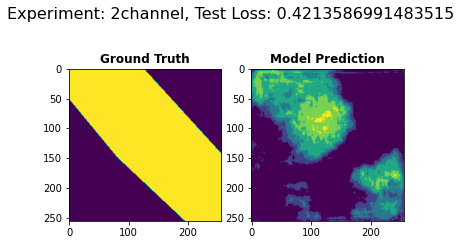

Text(0.5, 0.98, 'Experiment: 2channel, Test Loss: 0.4213586991483515')

tensor([[ 0.0409,  0.0987, -0.1605,  ...,  0.0756, -0.1051,  0.2665],
        [ 0.2597,  0.4005,  0.0982,  ...,  0.4291,  0.2512,  0.6033],
        [ 0.0584,  0.2005, -0.0225,  ...,  0.9944,  0.5055,  0.6840],
        ...,
        [ 0.1619,  0.0991, -0.0230,  ...,  0.4662,  0.4434,  0.4702],
        [ 0.1504,  0.2519,  0.1488,  ...,  0.6112,  1.0109,  0.8559],
        [ 0.0382,  0.2373,  0.2062,  ...,  0.6194,  1.0350,  0.6986]],
       grad_fn=<SqueezeBackward1>)

(1, 256, 256)


<AxesSubplot:title={'center':'Model Prediction'}>

<AxesSubplot:title={'center':'Ground Truth'}>

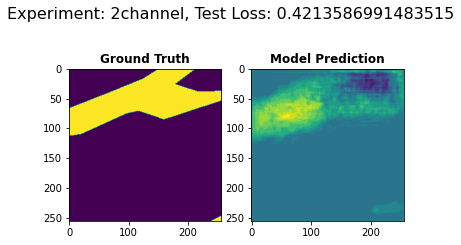

Text(0.5, 0.98, 'Experiment: 2channel, Test Loss: 0.4213586991483515')

tensor([[-0.0192,  0.0526, -0.1544,  ...,  0.0618,  0.0288,  0.2171],
        [ 0.2427,  0.3250,  0.1033,  ...,  0.2477,  0.2331,  0.4456],
        [ 0.1040,  0.1016, -0.1900,  ...,  0.3255,  0.2878,  0.5455],
        ...,
        [ 0.1628,  0.1447, -0.0495,  ...,  0.5654,  0.5499,  0.6192],
        [ 0.1246,  0.3163,  0.1468,  ...,  0.1307,  0.8310,  0.5920],
        [ 0.0351,  0.2526,  0.1996,  ...,  0.5540,  0.8805,  0.6593]],
       grad_fn=<SqueezeBackward1>)

(1, 256, 256)


<AxesSubplot:title={'center':'Model Prediction'}>

<AxesSubplot:title={'center':'Ground Truth'}>

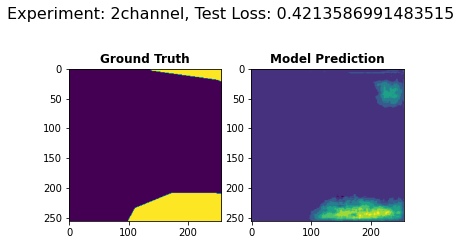

In [6]:
for e in experiments:
    id_num = int(e.get_system_properties()['id'].split('GIS-')[1])
    encoder = e.get_system_properties()['tags'][-1]
    if "encoder" in encoder:
        encoder = encoder.split("encoder")[1].lower()
    else:
        encoder = encoder.lower()
    if id_num == 307 and e.state == 'succeeded':
        # load in the model
        e.download_artifacts()
        with zipfile.ZipFile('output.zip') as zip_ref:
            zip_ref.extractall()
        f = open('output/latest_model.pkl', 'rb')
        device = torch.device('cpu')
        old_params = torch.load(f, map_location=device)
        params = dict()
        i_type = e.get_parameters()['image_type']
        if i_type == "full_channel":
            input_num = 4
        elif i_type == "rgb":
            input_num = 3
        elif i_type == "ir":
            input_num = 1
        elif i_type == "hsv":
            input_num = 3
        elif i_type == "hsv_with_ir":
            input_num = 4
        elif i_type == "veg_index":
            input_num = 1
        else:
            input_num = 4
        model = smp.Unet(classes=2, in_channels=4)
        # fix the weird state dict key error
        for k in old_params.keys():
            new_key = k.split("model.")[1]
            params[new_key] = old_params[k]
        # saving to variable to suppress huge printout
        print(encoder)
        y = model.load_state_dict(params)
        f.close()
        y = model.eval()
        # check the image type, and get image samples for corresponding image type
        # run the model on each of the samples and show results
        # print experiment id, name, image type, and training/test loss
        # print(e.get_properties(), e.get_numeric_channels_values())
        # show mask, and then show the results from each 
        for test in image_samples[i_type]:
            fig, (m_axis, i_axis) = pyplot.subplots(1, 2)
            fig.suptitle("Experiment: "+encoder+", Test Loss: "+e.get_logs()['test_loss']['y'], fontsize=16)
            if i_type == "veg_index":
                channel_input = test['image'].unsqueeze(0)
                channel_input = channel_input.unsqueeze(1)
                res = model(channel_input)
            else:
                output = model(test['image'].unsqueeze(0))
            res = torch.max(output[:, 0, :, :], output[:, 1, :, :])
            res.squeeze(0)
            res = np.rint(res.detach().numpy())
#             res = torch.max(model(test['image'].unsqueeze(0)))
            #res = np.reshape(res, (2, 256, 256))
            print(res.shape) 
            #print(res[:10])
            show(res, ax=i_axis, title="Model Prediction")
            show(test['mask'], ax=m_axis, title="Ground Truth")
            pyplot.show()
    

In [7]:
res

array([[[-0.,  0., -0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0., -0., ...,  0.,  0.,  1.],
        ...,
        [ 0.,  0., -0., ...,  1.,  1.,  1.],
        [ 0.,  0.,  0., ...,  0.,  1.,  1.],
        [ 0.,  0.,  0., ...,  1.,  1.,  1.]]], dtype=float32)

In [ ]:
from scipy.special import softmax
unmodified_res[:10]
calculation = softmax(unmodified_res)
calculation[:10]
show(np.rint(calculation))

In [ ]:
test['mask']

In [ ]:
for e in experiments:
    # load in the model
    e.download_artifacts()
    with zipfile.ZipFile('output.zip') as zip_ref:
        zip_ref.extractall()
    f = open('output/latest_model.pkl', 'rb')
    device = torch.device('cpu')
    old_params = torch.load(f, map_location=device)
    params = dict()
    i_type = e.get_parameters()['image_type']
    if i_type == "full_channel":
        input_num = 4
    elif i_type == "rgb":
        input_num = 3
    elif i_type == "ir":
        input_num = 1
    elif i_type == "hsv":
        input_num = 3
    elif i_type == "hsv_with_ir":
        input_num = 4
    elif i_type == "veg_index":
        input_num = 1
    else:
        i_type = 4
    model =  torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet', in_channels=input_num,
                                    out_channels=1,
                                    init_features=32, pretrained=False)
    # fix the weird state dict key error
    for k in old_params.keys():
        new_key = k.split("model.")[1]
        params[new_key] = old_params[k]
    model.load_state_dict(params)
    f.close()
    # check the image type, and get image samples for corresponding image type
    # run the model on each of the samples and show results
    # print experiment id, name, image type, and training/test loss
    # print(e.get_properties(), e.get_numeric_channels_values())
    # show mask, and then show the results from each 
    for test in image_samples[i_type]:
        fig, (m_axis, i_axis) = pyplot.subplots(1, 2)
        fig.suptitle("Experiment: "+e.get_system_properties()['name']+", Test Loss: "+e.get_logs()['test_loss']['y'], fontsize=16)
        if i_type == "veg_index":
            channel_input = test['image'].unsqueeze(0)
            channel_input = channel_input.unsqueeze(1)
            res = model(channel_input)
        else:
            res = model(test['image'].unsqueeze(0))
        res = np.rint(res.detach().numpy())
        show(res, ax=i_axis, title="Model Prediction")
        show(test['mask'], ax=m_axis, title="Ground Truth")
        pyplot.show()
    